# Show how increasing dimensionality helps classification

In [1]:
%matplotlib inline
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from random import shuffle

# Get the data

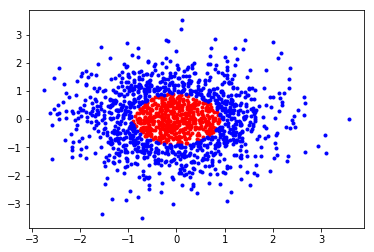

In [2]:
# number of features in
nf   = 2
# number of classes
nClass = 2

X = torch.randn(2,1500)
R = torch.sqrt(X[0,:]**2 + X[1,:]**2)
indRed   = (R < 0.9).nonzero()
indBlue  = (R >= 0.9).nonzero()


C = torch.zeros(1500,dtype = torch.int64)
C[indRed]  = 0
C[indBlue] = 1

plt.plot(X.numpy()[0,indRed],X.numpy()[1,indRed],'.r')
plt.plot(X.numpy()[0,indBlue],X.numpy()[1,indBlue],'.b')


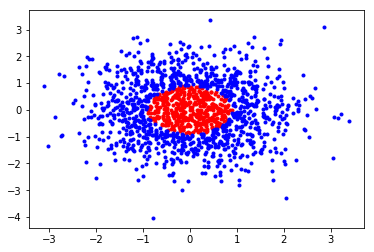

In [3]:
# Get a validation set
XVal = torch.randn(2,1500)
R = torch.sqrt(XVal[0,:]**2 + XVal[1,:]**2)
indRed   = (R < 0.9).nonzero()
indBlue  = (R >= 0.9).nonzero()


CVal = torch.zeros(1500,dtype = torch.int64)
CVal[indRed]  = 0
CVal[indBlue] = 1

plt.plot(XVal.numpy()[0,indRed],XVal.numpy()[1,indRed],'.r')
plt.plot(XVal.numpy()[0,indBlue],XVal.numpy()[1,indBlue],'.b')

# Design the simple ResNet

In [4]:
lossFunc = nn.CrossEntropyLoss()

def misfit(X,W,bias,C):
    n = W.shape
    X = X.view(n[1],-1)
    S = torch.matmul(W,X) 
    S += bias.unsqueeze(1)
    return lossFunc(S.t(),C)

In [48]:
class RK4Net(nn.Module):

    def __init__(self,NetGeo):
        super().__init__()
        
        self.NetGeo = NetGeo
        
    def forward(self,x,K0,K,b):
        dt = self.NetGeo[1]
        nt = self.NetGeo[0]
        
        # First layer open up
        #x = F.relu(torch.matmul(K0,x) + b[0])
        x = torch.matmul(K0,x)
        
        # Allocate space for all times
        X  = torch.zeros(x.shape[0],x.shape[1],nt+1)
        X[:,:,0] = x
        
        # forward Euler (to be improved later)
        for i in range(nt):
            k1 = F.relu(torch.matmul(K[i],x) + b[i])
            k2 = F.relu(torch.matmul(K[i],x+k1/2.0) + b[i])
            k3 = F.relu(torch.matmul(K[i],x+k2/2.0) + b[i])
            k4 = F.relu(torch.matmul(K[i],x+k3) + b[i])
            
            x = x + dt/6.0*(k1+k2+k3+k4)
            ind = i+1
            X[:,:,ind] = x
            
            
        return x,X 


# Initialize all parameter

In [56]:
dt = 0.1
nt = 64
nfNet = 3
NG    = [nt,dt]
net   = RK4Net(NG)

# initialize K's
K0  = nn.Parameter(torch.randn(nfNet, nf))
K = []
for i in range(nt):
    Ki  = nn.Parameter(torch.randn(nfNet, nfNet)*1e-3)
    K.append(Ki)
    
b  = nn.Parameter(torch.randn(nt)*1e-3)
        

In [57]:
# Run the network
xF,Xpath = net(X,K0,K,b)

In [58]:

# weights for linear classifier    
W      = nn.Parameter(torch.randn(nClass,nfNet)*1e-3,requires_grad=True)
bW     = nn.Parameter(torch.randn(nClass)*1e-2,requires_grad=True)

nparout = np.prod(K0.shape) + np.prod(W.shape) + np.prod(bW.shape) + np.prod(K[0].shape)*nt + nt

print('Total number of parameter',nparout)
print('Total number of data',C.shape[0])

Total number of parameter 654
Total number of data 1500


In [59]:
# run the network
x,_ = net(X,K0,K,b)
label = C
print(W.shape)
loss = misfit(x,W,bW,label)
print('Initial loss = ', loss.detach().numpy())    
print('Sanity Check = ',np.log(2.0))

torch.Size([2, 3])
Initial loss =  0.69273806
Sanity Check =  0.6931471805599453


In [53]:
batchSize = 16

In [60]:
import torch.optim as optim
optimizer = optim.SGD([{'params': W},{'params': K},{'params': bW},{'params': b}], lr = 1e-1,momentum=0.0)

In [61]:
for epoch in range(30):  # loop over the dataset multiple times

    # zero the parameter gradients
    g = 0.0
    loss = 0.0
    ind = 0
    while ind<X.shape[1]:    
        optimizer.zero_grad()
        # get the inputs
        inputs = X[:,ind:ind+batchSize]
        labels = C[ind:ind+batchSize]

        # forward 
        x,_   = net(inputs,K0,K,b)
        lossi = misfit(x,W,bW,labels)
        if i==0:
            loss = lossi
        else:
            loss  += lossi
            
        lossi.backward()
        optimizer.step()
        g += torch.norm(W.grad) + torch.norm(bW.grad)    
        ind += batchSize
        
    print('%d  %.3f   %.3f'% (epoch+1, loss, g))

print('Finished Training')

1  61.381   59.284
2  60.451   53.118
3  59.865   51.202
4  56.672   45.959
5  50.534   40.407
6  45.195   37.037
7  40.274   33.760
8  34.859   30.487
9  29.601   27.554
10  25.240   25.288
11  22.004   23.581
12  19.647   22.305
13  17.837   21.277
14  16.401   20.418
15  15.195   19.680
16  14.177   19.051
17  13.320   18.521
18  12.582   18.056
19  11.936   17.647
20  11.369   17.290
21  10.856   16.960
22  10.385   16.658
23  9.940   16.364
24  9.548   16.095
25  9.197   15.838
26  8.871   15.595
27  8.565   15.367
28  8.275   15.147
29  8.007   14.954
30  7.760   14.769
Finished Training


# Plot the results on validation

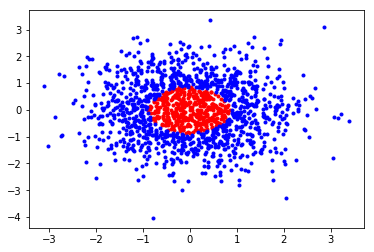

In [62]:
x,_      = net(XVal,K0,K,b)
S      = torch.matmul(W,x)
S     += bW.unsqueeze(1)
_,Cpred = torch.max(S,dim=0)


indRed   = (Cpred==0).nonzero()
indBlue  = (Cpred==1).nonzero()


plt.plot(XVal[0,indRed].numpy(),XVal[1,indRed].numpy(),'.r')
plt.plot(XVal[0,indBlue].numpy(),XVal[1,indBlue].numpy(),'.b')


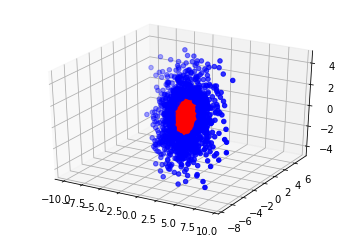

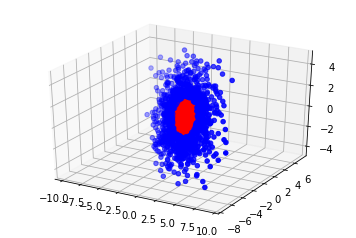

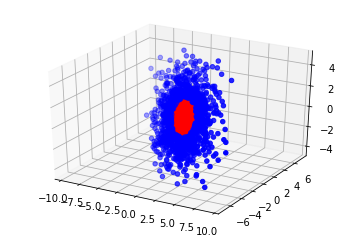

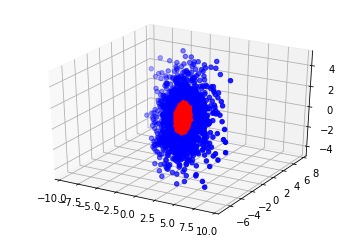

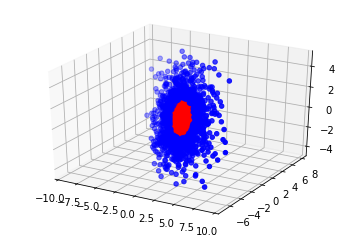

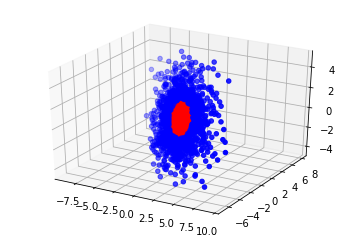

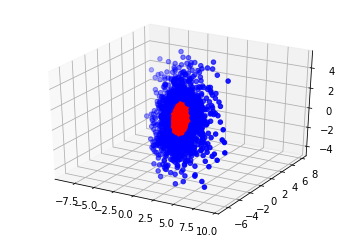

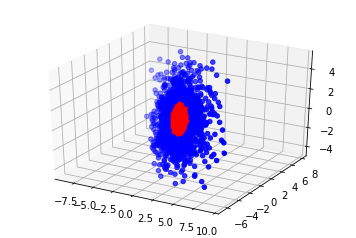

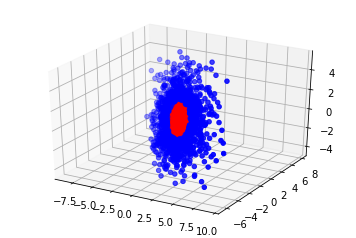

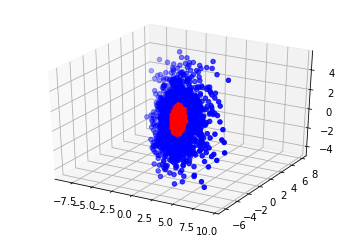

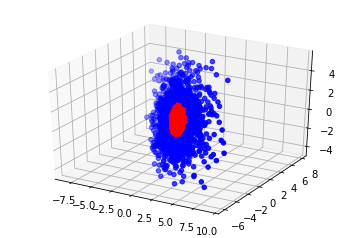

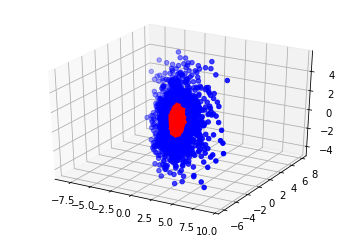

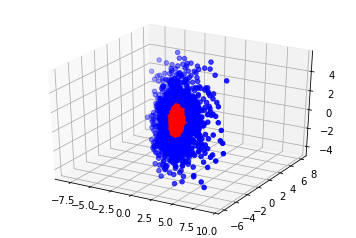

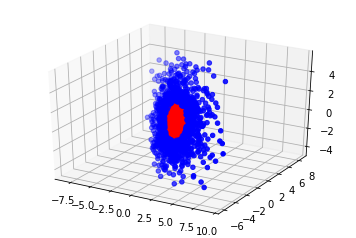

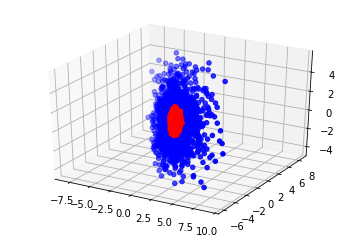

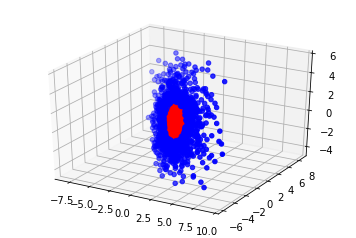

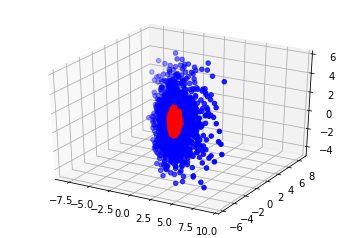

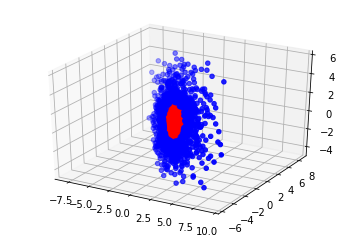

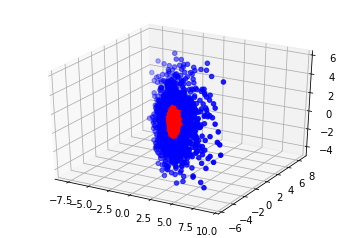

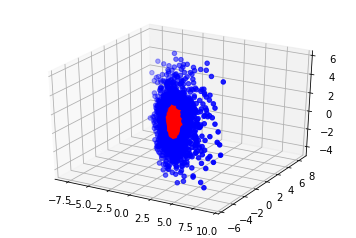

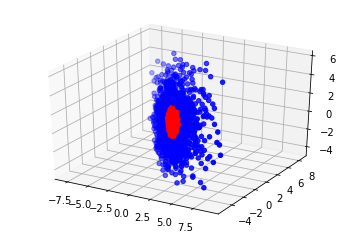

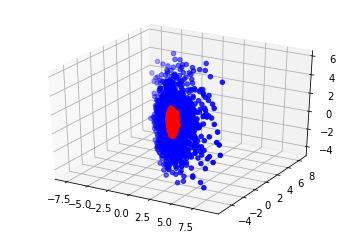

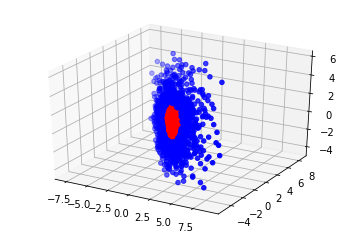

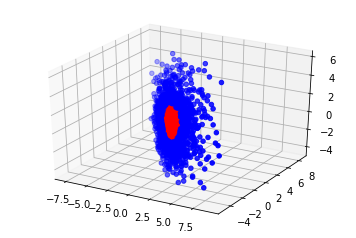

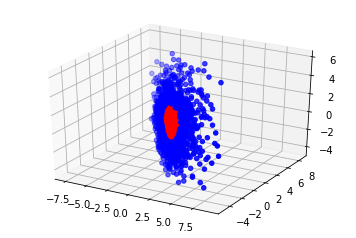

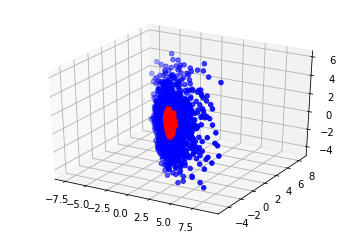

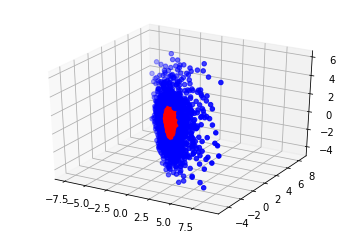

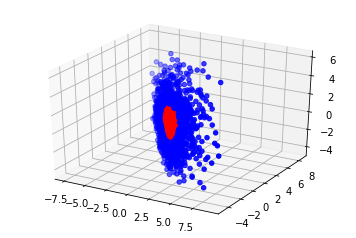

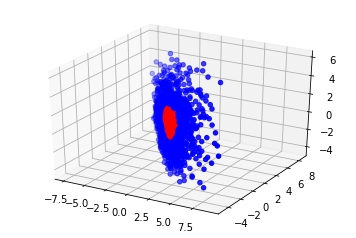

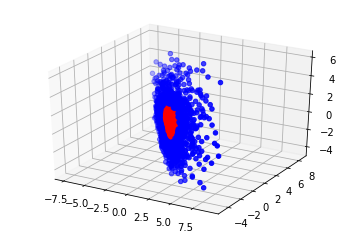

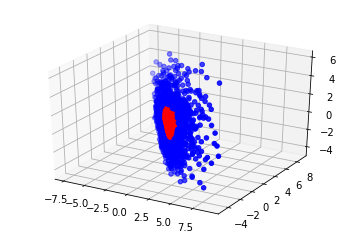

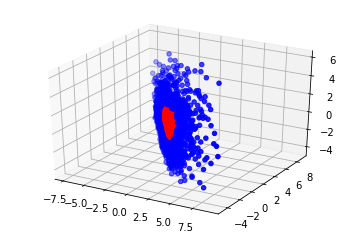

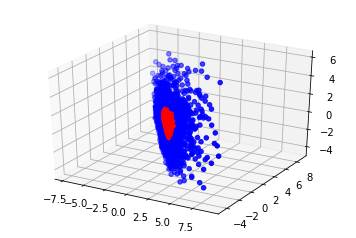

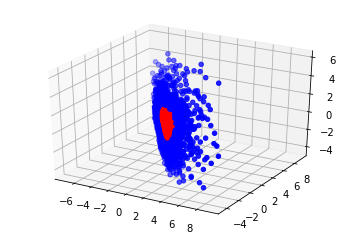

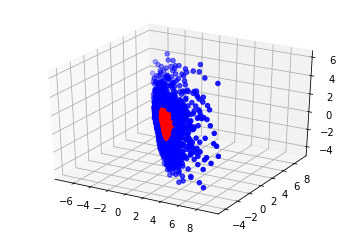

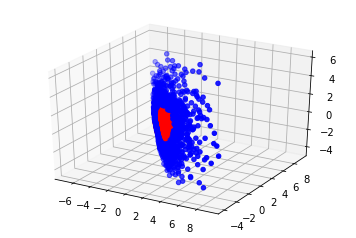

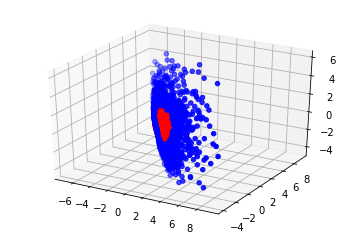

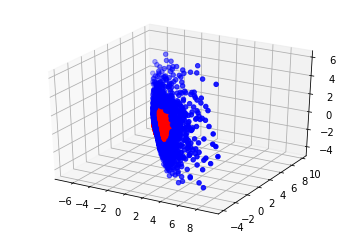

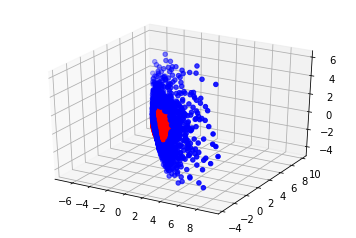

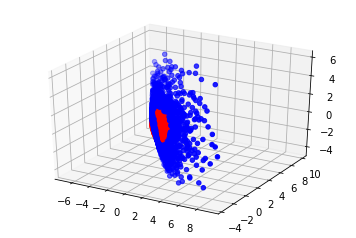

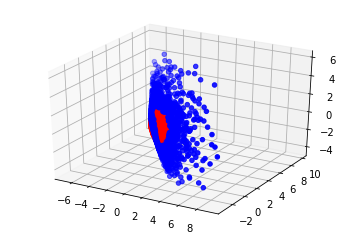

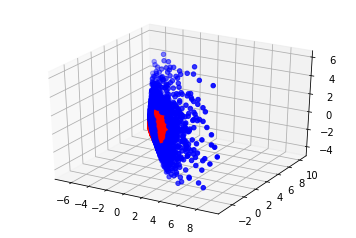

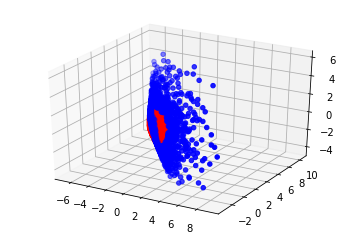

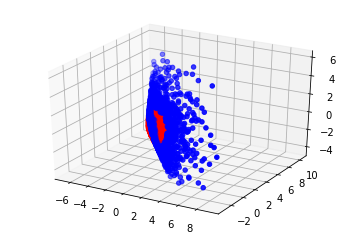

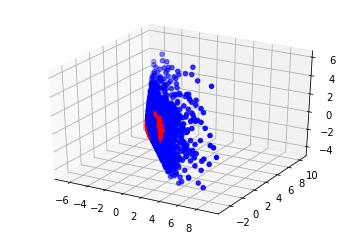

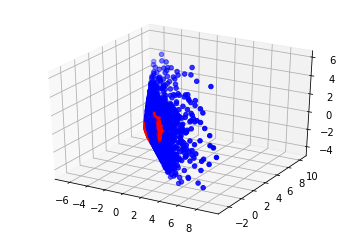

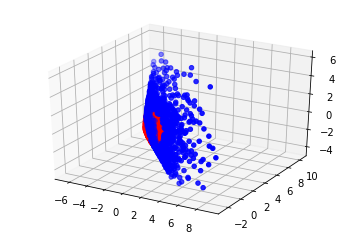

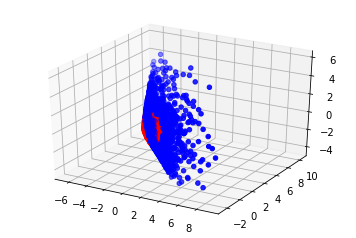

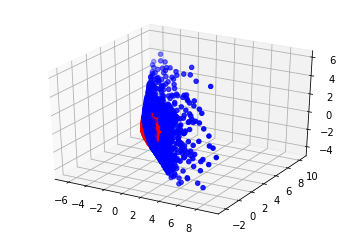

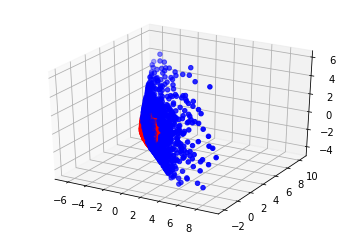

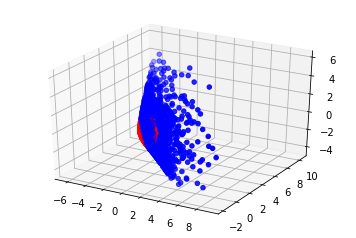

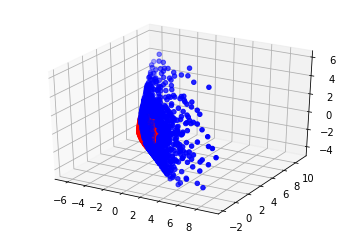

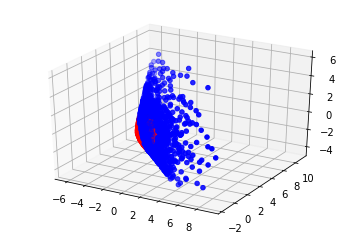

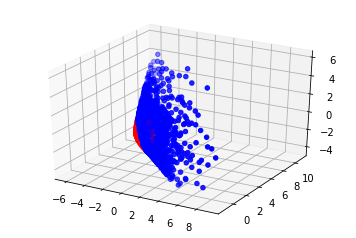

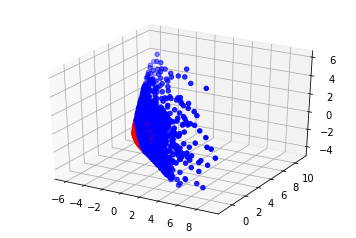

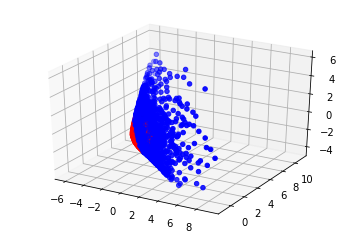

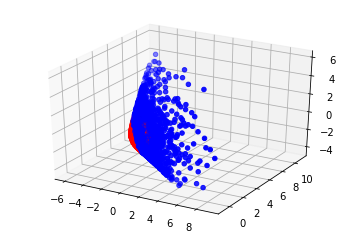

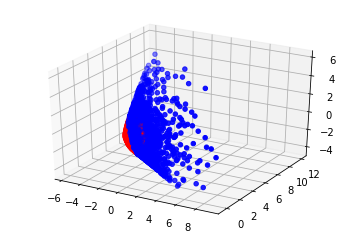

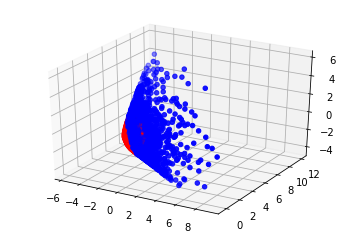

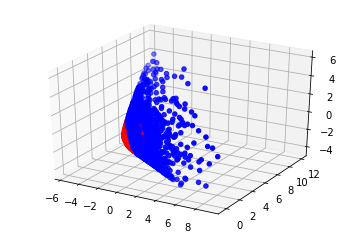

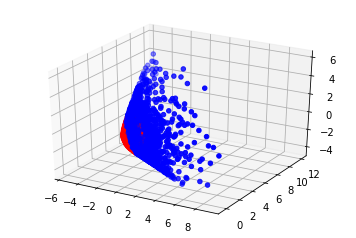

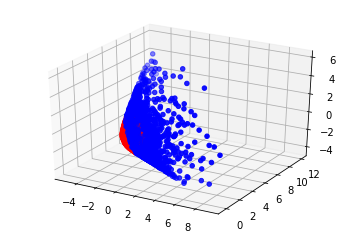

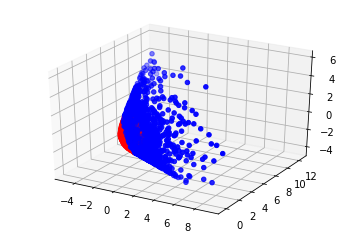

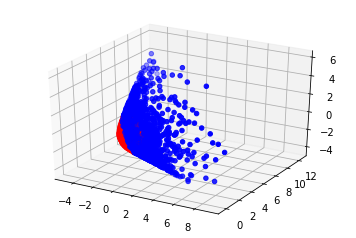

In [65]:
# plot the path
from mpl_toolkits.mplot3d import Axes3D

x,Xpath      = net(X,K0,K,b)

indRed   = (C==0).nonzero()
indBlue  = (C==1).nonzero()


for i in range(64):
    Xi = Xpath[:,:,i].detach().numpy()    
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(Xi[0,indRed],Xi[1,indRed],Xi[2,indRed], c='r')
    ax.scatter(Xi[0,indBlue],Xi[1,indBlue],Xi[2,indBlue], c='b')

    plt.pause(0.1)